# Проект: Прогнозирование заказов такси

<b>Описание проекта</b>
<p>
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 
</p>

**Цель:** требуется построить модель для такого предсказания

<b>Задачи:</b>
<ol>
<li>Первая —  построить модель для построения прогноза заказов на следующий час.</li>
<li>Проверить работу модели на тестовой выборке.</li>
</ol>

## Подключение необходимых библиотек

In [1]:
!pip install scikit-learn==1.4 -q
!pip install pandas==1.5.0 -q
!pip install lightgbm -q
!pip install catboost -q

import pandas as pd
import os
import platform
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from scipy import stats as st
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

# загружаем классы для подготовки данных
from sklearn.compose import ColumnTransformer

# загружаем pipeline, нужные модели и метрики
from numpy.random import RandomState
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## 1.1 Загрузка данных

Прочитаем исходные данные из файла

In [2]:
datasets_path='/datasets/'
if platform.system()=='Windows':
    cwd = os.getcwd()
    datasets_path= os.getcwd()+'\\datasets\\'
data= pd.read_csv(datasets_path+'taxi.csv', sep=',', index_col=[0], parse_dates=[0])

##  1.2 Предобработка данных

Выведем общую информацию и первые 10 строк файла data.csv для контроля загрузки и первого знакомства с данными

In [3]:
print(data.info())
data.head(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


**Вывод: пропуски в данных не обнаружены, временной ряд составляют интервалы в 10 минут (монотонность надо еще проверить).**

#### 1.2.1 Проверка, что индекс монотонный

In [4]:
data= data.sort_index()
print(data.index.is_monotonic)

True


**Вывод: индекс монотонный, можно анализировать временной ряд**

## 2. Ресемплирование и анализ данных

In [5]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Построим график временного ряда со скользящим средним

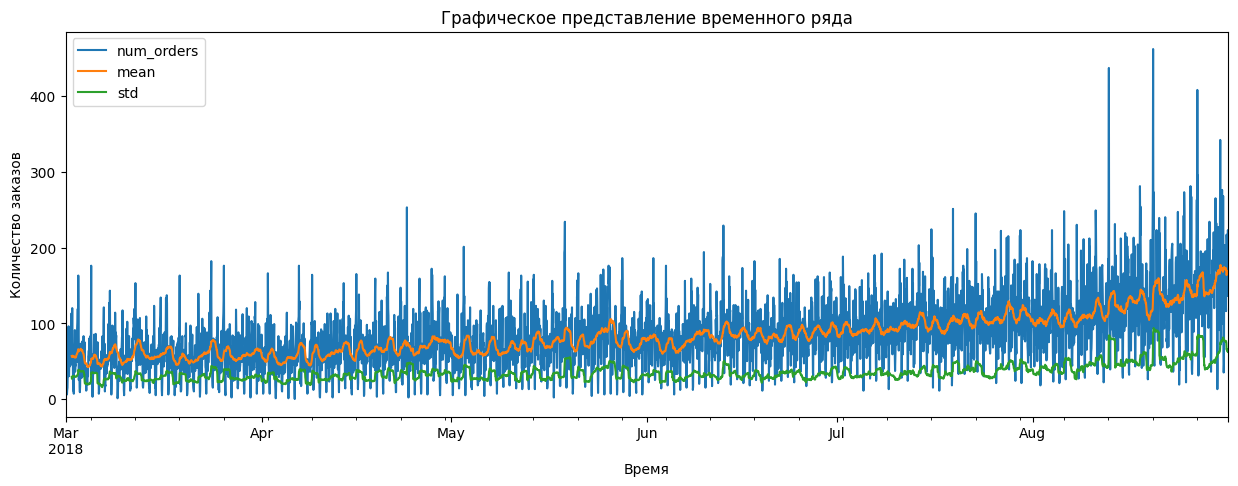

In [6]:
plt_data= data.copy()
fig, ax = plt.subplots(figsize=(15,5))
plt_data['mean']= plt_data['num_orders'].rolling(24).mean()
plt_data['std']= plt_data['num_orders'].rolling(24).std()
plt_data.plot(
    ax= ax,
    title='Графическое представление временного ряда',
    xlabel='Время',
    ylabel='Количество заказов'
)
plt.show()

Вывод: временной ряд не является стационарным так как его среднее и дисперсия возрастают. Проанализируем тренды и сезонность

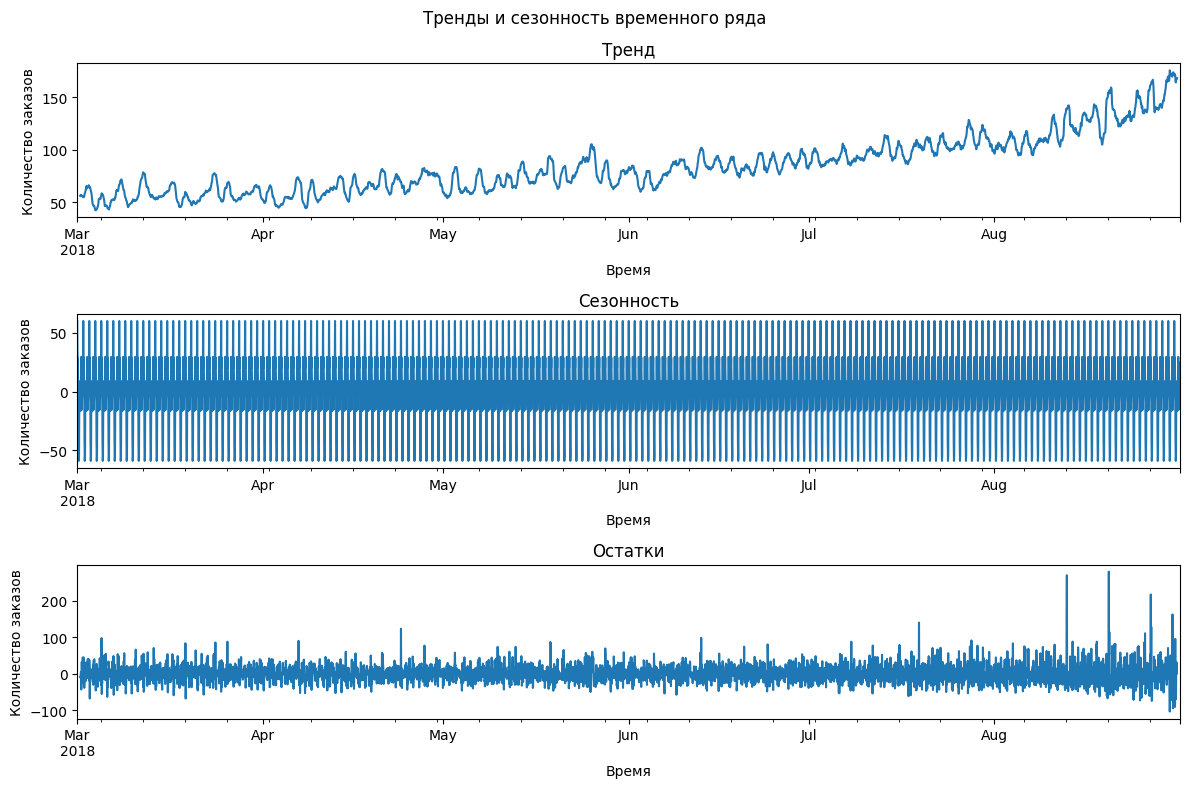

In [7]:
decomposed = seasonal_decompose(data) 
plt.figure(figsize=(12, 8))
plt.suptitle('Тренды и сезонность временного ряда')
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.title('Остатки')
plt.tight_layout()

Похоже, что сезонная составляющая носит стационарных характер. Декомпозируем ее в пределах 2-3 дней дня чтобы уловить закономерности

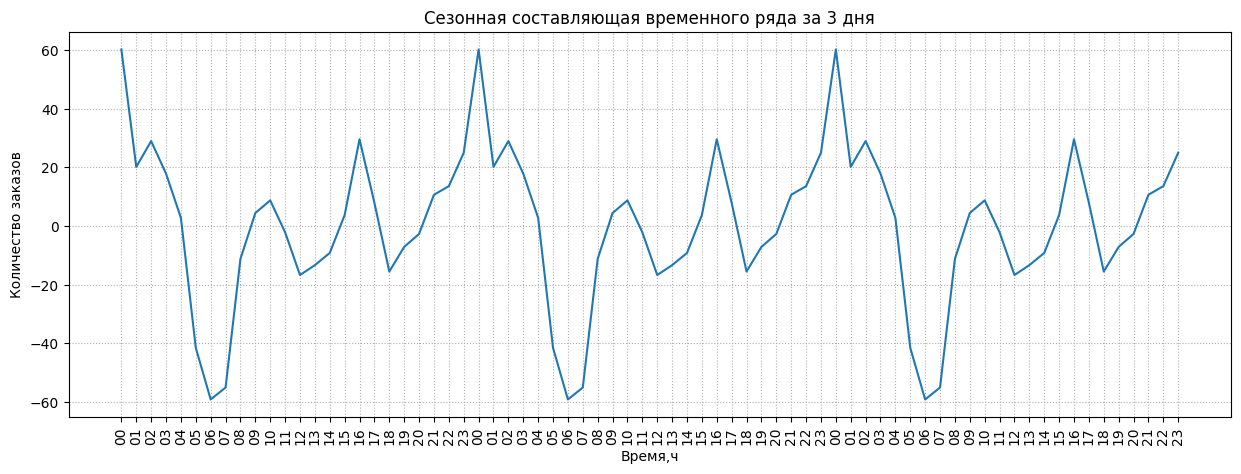

In [8]:
seasonal= decomposed.seasonal['2018-03-01':'2018-03-03']
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(seasonal.index,seasonal.values)
ax.set_ylabel('Количество заказов')
ax.set_xlabel('Время,ч')
ax.set_xticks(seasonal.index)
ax.set_title('Сезонная составляющая временного ряда за 3 дня')
# use formatters to specify major and minor ticks
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H"))
_ = plt.xticks(rotation=90)
plt.grid(True, linestyle = ':')
plt.show()

Вывод: по графику видно, что каждый день начиная с 0 часов ночи количество заказов постепенно снижается, достигая минимума к 6 утра. Затем повышается с колебаниями и локальными максимами в районе 10 и 16 часов,а с 18 часов растет достигая пика в районе 0 ночи.

## 3.Создание признаков

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data, 2, 24)
data.head(10)

,num_orders,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,NaN
2018-03-01 05:00:00,6,3,5,43.0,66.0,NaN
2018-03-01 06:00:00,12,3,6,6.0,43.0,NaN
2018-03-01 07:00:00,15,3,7,12.0,6.0,NaN
2018-03-01 08:00:00,34,3,8,15.0,12.0,NaN


## 4.Обучение моделей

#### 4.1 Разделим выборку на тренировочную и тестовую

In [10]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
X_train = train.drop(columns=['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(columns=['num_orders'], axis=1)
y_test = test['num_orders']

#### 4.2 Обучим модели

#### 4.2.1 Обучим и сделаем предсказание с помощью константной модели DummyRegressor

In [11]:
dummy_model= DummyRegressor(strategy='median')
dummy_model.fit(X_train, y_train)
dummy_pred= dummy_model.predict(X_test)
dummy_rmse= root_mean_squared_error(y_test.tolist(), dummy_pred) 
print(f'Метрика RMSE константной модели на тестовой выборке: {round(dummy_rmse,2)}')

Метрика RMSE константной модели на тестовой выборке: 87.15


#### 4.2.2 Создаём общий пайплайн для подготовки данных

In [12]:
num_columns= X_train.columns
num_columns

Index(['dayofweek', 'hour', 'lag_1', 'lag_2', 'rolling_mean'], dtype='object')

In [13]:
data_preprocessor = ColumnTransformer(
    [('num', ['passthrough'], num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [14]:
RANDOM_STATE = 77
param_grid = [
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression(
        )],
       'preprocessor__num': ['passthrough'] 
    },
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,8),
        'models__min_samples_leaf': range(2,8),
        'models__min_samples_split': range(2,8),
        'preprocessor__num': ['passthrough'] 
    },
    #словарь для модели LGBMRegressor
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,8),
        'models__num_leaves': range(2,16),
        'preprocessor__num': ['passthrough']
    },
    #словарь для модели CatBoostRegressor
    {
        'models': [CatBoostRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,8),
        'preprocessor__num': ['passthrough'] 
    }
    
]


создаем параметры для кросс-валидации временного ряда

In [15]:
tscv = TimeSeriesSplit(n_splits=8)
for train, test in tscv.split(X_train):
    to_month= round(train.flat[len(train)-1]/24/30,1)
    print(f'выборка train:{len(train)} элементов с {train.flat[0]} по {train.flat[len(train)-1]} ч ({to_month}) мес')
    to_month_test= round(test.flat[len(test)-1]/24/30,1)
    print(f'выборка test:{len(test)} элементов с {test.flat[0]} по {test.flat[len(test)-1]} ч ({to_month_test}) мес\n')

выборка train:446 элементов с 0 по 445 ч (0.6) мес
выборка test:438 элементов с 446 по 883 ч (1.2) мес

выборка train:884 элементов с 0 по 883 ч (1.2) мес
выборка test:438 элементов с 884 по 1321 ч (1.8) мес

выборка train:1322 элементов с 0 по 1321 ч (1.8) мес
выборка test:438 элементов с 1322 по 1759 ч (2.4) мес

выборка train:1760 элементов с 0 по 1759 ч (2.4) мес
выборка test:438 элементов с 1760 по 2197 ч (3.1) мес

выборка train:2198 элементов с 0 по 2197 ч (3.1) мес
выборка test:438 элементов с 2198 по 2635 ч (3.7) мес

выборка train:2636 элементов с 0 по 2635 ч (3.7) мес
выборка test:438 элементов с 2636 по 3073 ч (4.3) мес

выборка train:3074 элементов с 0 по 3073 ч (4.3) мес
выборка test:438 элементов с 3074 по 3511 ч (4.9) мес

выборка train:3512 элементов с 0 по 3511 ч (4.9) мес
выборка test:438 элементов с 3512 по 3949 ч (5.5) мес



Вывод: для кросс-валидации нет смысла использовать параметр n_splits>8 тк наша выборка для обучения не превышает 6 месяцев

In [16]:
cv_search = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    cv= tscv,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_iter=50,
    n_jobs=-1,
    error_score='raise',
    verbose=False
)
cv_search.fit(X_train, y_train)
print('Лучшая модель:\n\n', cv_search.best_estimator_)
print ('Параметры лучшей модели:', cv_search.best_params_)
print ('Метрика RMSE лучшей модели на тренировочной выборке:', round(-1*cv_search.best_score_,2))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 5
[LightGBM] [Info] Start training from score 78.421013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Лучшая модель:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  Index(['dayofweek', 'hour', 'lag_1', 'lag_2', 'rolling_mean'], d

844:	learn: 12.5066702	total: 1.35s	remaining: 247ms
845:	learn: 12.5024728	total: 1.35s	remaining: 246ms
846:	learn: 12.4974470	total: 1.35s	remaining: 244ms
847:	learn: 12.4841607	total: 1.35s	remaining: 243ms
848:	learn: 12.4790372	total: 1.35s	remaining: 241ms
849:	learn: 12.4729016	total: 1.36s	remaining: 240ms
850:	learn: 12.4694168	total: 1.36s	remaining: 238ms
851:	learn: 12.4638552	total: 1.36s	remaining: 236ms
852:	learn: 12.4584931	total: 1.36s	remaining: 235ms
853:	learn: 12.4550509	total: 1.36s	remaining: 233ms
854:	learn: 12.4426704	total: 1.36s	remaining: 232ms
855:	learn: 12.4384487	total: 1.37s	remaining: 230ms
856:	learn: 12.4338058	total: 1.37s	remaining: 228ms
857:	learn: 12.4286405	total: 1.37s	remaining: 227ms
858:	learn: 12.4265731	total: 1.37s	remaining: 225ms
859:	learn: 12.4203908	total: 1.37s	remaining: 224ms
860:	learn: 12.4121221	total: 1.37s	remaining: 222ms
861:	learn: 12.4056153	total: 1.38s	remaining: 220ms
862:	learn: 12.3994107	total: 1.38s	remaining:

Learning rate set to 0.050906
0:	learn: 37.7213984	total: 2.04ms	remaining: 2.04s
1:	learn: 36.8762011	total: 4.09ms	remaining: 2.04s
2:	learn: 36.0026456	total: 5.89ms	remaining: 1.96s
3:	learn: 35.3777252	total: 7.61ms	remaining: 1.89s
4:	learn: 34.6524155	total: 9.39ms	remaining: 1.87s
5:	learn: 34.1304505	total: 11.3ms	remaining: 1.87s
6:	learn: 33.4343217	total: 13.2ms	remaining: 1.87s
7:	learn: 32.8280684	total: 15.1ms	remaining: 1.87s
8:	learn: 32.2940861	total: 16.8ms	remaining: 1.84s
9:	learn: 31.8655016	total: 18.5ms	remaining: 1.83s
10:	learn: 31.3298714	total: 20.3ms	remaining: 1.82s
11:	learn: 30.8718145	total: 22.1ms	remaining: 1.82s
12:	learn: 30.4697607	total: 24ms	remaining: 1.82s
13:	learn: 30.0282946	total: 25.8ms	remaining: 1.81s
14:	learn: 29.6244380	total: 27.5ms	remaining: 1.8s
15:	learn: 29.3169334	total: 29.2ms	remaining: 1.79s
16:	learn: 29.0578450	total: 31.1ms	remaining: 1.79s
17:	learn: 28.7446186	total: 32.8ms	remaining: 1.79s
18:	learn: 28.4872602	total: 

183:	learn: 20.4943774	total: 336ms	remaining: 1.49s
184:	learn: 20.4763391	total: 338ms	remaining: 1.49s
185:	learn: 20.4588718	total: 339ms	remaining: 1.48s
186:	learn: 20.4362135	total: 341ms	remaining: 1.48s
187:	learn: 20.4226345	total: 343ms	remaining: 1.48s
188:	learn: 20.4020440	total: 345ms	remaining: 1.48s
189:	learn: 20.3759114	total: 346ms	remaining: 1.48s
190:	learn: 20.3568874	total: 348ms	remaining: 1.47s
191:	learn: 20.3551498	total: 350ms	remaining: 1.47s
192:	learn: 20.3450567	total: 351ms	remaining: 1.47s
193:	learn: 20.3343045	total: 353ms	remaining: 1.47s
194:	learn: 20.3319741	total: 355ms	remaining: 1.46s
195:	learn: 20.3286190	total: 357ms	remaining: 1.46s
196:	learn: 20.3267846	total: 358ms	remaining: 1.46s
197:	learn: 20.2930656	total: 360ms	remaining: 1.46s
198:	learn: 20.2860149	total: 362ms	remaining: 1.46s
199:	learn: 20.2652125	total: 364ms	remaining: 1.45s
200:	learn: 20.2493979	total: 365ms	remaining: 1.45s
201:	learn: 20.2386887	total: 367ms	remaining:

373:	learn: 17.6664336	total: 682ms	remaining: 1.14s
374:	learn: 17.6595952	total: 684ms	remaining: 1.14s
375:	learn: 17.6586345	total: 685ms	remaining: 1.14s
376:	learn: 17.6429460	total: 687ms	remaining: 1.14s
377:	learn: 17.6274694	total: 689ms	remaining: 1.13s
378:	learn: 17.6229229	total: 691ms	remaining: 1.13s
379:	learn: 17.6220741	total: 692ms	remaining: 1.13s
380:	learn: 17.6171580	total: 694ms	remaining: 1.13s
381:	learn: 17.6020583	total: 696ms	remaining: 1.13s
382:	learn: 17.6012955	total: 697ms	remaining: 1.12s
383:	learn: 17.6006012	total: 699ms	remaining: 1.12s
384:	learn: 17.5903232	total: 701ms	remaining: 1.12s
385:	learn: 17.5804330	total: 703ms	remaining: 1.12s
386:	learn: 17.5643652	total: 704ms	remaining: 1.11s
387:	learn: 17.5539039	total: 706ms	remaining: 1.11s
388:	learn: 17.5480778	total: 708ms	remaining: 1.11s
389:	learn: 17.5380133	total: 709ms	remaining: 1.11s
390:	learn: 17.5269366	total: 711ms	remaining: 1.11s
391:	learn: 17.5117048	total: 714ms	remaining:

568:	learn: 15.8927546	total: 1.02s	remaining: 773ms
569:	learn: 15.8809182	total: 1.02s	remaining: 771ms
570:	learn: 15.8716579	total: 1.02s	remaining: 769ms
571:	learn: 15.8565351	total: 1.02s	remaining: 768ms
572:	learn: 15.8479953	total: 1.03s	remaining: 766ms
573:	learn: 15.8374519	total: 1.03s	remaining: 764ms
574:	learn: 15.8322051	total: 1.03s	remaining: 762ms
575:	learn: 15.8225673	total: 1.03s	remaining: 760ms
576:	learn: 15.8135974	total: 1.03s	remaining: 758ms
577:	learn: 15.8014790	total: 1.04s	remaining: 757ms
578:	learn: 15.7930878	total: 1.04s	remaining: 755ms
579:	learn: 15.7880760	total: 1.04s	remaining: 753ms
580:	learn: 15.7779387	total: 1.04s	remaining: 751ms
581:	learn: 15.7735702	total: 1.04s	remaining: 749ms
582:	learn: 15.7713796	total: 1.04s	remaining: 747ms
583:	learn: 15.7670359	total: 1.05s	remaining: 745ms
584:	learn: 15.7582761	total: 1.05s	remaining: 743ms
585:	learn: 15.7446795	total: 1.05s	remaining: 742ms
586:	learn: 15.7370587	total: 1.05s	remaining:

768:	learn: 14.5225635	total: 1.38s	remaining: 414ms
769:	learn: 14.5132120	total: 1.38s	remaining: 412ms
770:	learn: 14.5105780	total: 1.38s	remaining: 411ms
771:	learn: 14.5043416	total: 1.38s	remaining: 409ms
772:	learn: 14.5011858	total: 1.39s	remaining: 407ms
773:	learn: 14.4955793	total: 1.39s	remaining: 405ms
774:	learn: 14.4877961	total: 1.39s	remaining: 403ms
775:	learn: 14.4875233	total: 1.39s	remaining: 402ms
776:	learn: 14.4738947	total: 1.39s	remaining: 400ms
777:	learn: 14.4666096	total: 1.39s	remaining: 398ms
778:	learn: 14.4582280	total: 1.4s	remaining: 396ms
779:	learn: 14.4494311	total: 1.4s	remaining: 394ms
780:	learn: 14.4420998	total: 1.4s	remaining: 393ms
781:	learn: 14.4398373	total: 1.4s	remaining: 391ms
782:	learn: 14.4359938	total: 1.4s	remaining: 389ms
783:	learn: 14.4308021	total: 1.41s	remaining: 387ms
784:	learn: 14.4268144	total: 1.41s	remaining: 385ms
785:	learn: 14.4226119	total: 1.41s	remaining: 384ms
786:	learn: 14.4176133	total: 1.41s	remaining: 382m

955:	learn: 13.4254245	total: 1.72s	remaining: 79.3ms
956:	learn: 13.4188113	total: 1.73s	remaining: 77.5ms
957:	learn: 13.4135907	total: 1.73s	remaining: 75.8ms
958:	learn: 13.4056826	total: 1.73s	remaining: 74ms
959:	learn: 13.4002260	total: 1.73s	remaining: 72.2ms
960:	learn: 13.3908167	total: 1.73s	remaining: 70.3ms
961:	learn: 13.3841884	total: 1.74s	remaining: 68.5ms
962:	learn: 13.3762669	total: 1.74s	remaining: 66.7ms
963:	learn: 13.3751088	total: 1.74s	remaining: 64.9ms
964:	learn: 13.3731346	total: 1.74s	remaining: 63.1ms
965:	learn: 13.3667111	total: 1.74s	remaining: 61.3ms
966:	learn: 13.3600053	total: 1.74s	remaining: 59.5ms
967:	learn: 13.3527801	total: 1.75s	remaining: 57.7ms
968:	learn: 13.3457146	total: 1.75s	remaining: 55.9ms
969:	learn: 13.3432349	total: 1.75s	remaining: 54.1ms
970:	learn: 13.3368347	total: 1.75s	remaining: 52.3ms
971:	learn: 13.3306925	total: 1.75s	remaining: 50.5ms
972:	learn: 13.3258082	total: 1.75s	remaining: 48.7ms
973:	learn: 13.3233267	total: 

Предсказание и расчет метрики на тестовой выборке

In [17]:
y_pred= cv_search.best_estimator_.predict(X_test)
RMSE = root_mean_squared_error(y_test.tolist(), y_pred) 
print(f'Метрика RMSE лучшей модели на тестовой выборке: {round(RMSE,2)}')

Метрика RMSE лучшей модели на тестовой выборке: 44.42


Построим графики для сравнения тестовой выборки и предсказаний

In [18]:
plt_data = pd.concat([y_test, pd.DataFrame(y_pred, columns=['predicted_orders'], index= X_test.index)], axis=1)
plt_data.columns=['true_orders', 'predicted_orders']
plt_data.head()

,true_orders,predicted_orders
datetime,,
2018-08-13 14:00:00,102,101.675684
2018-08-13 15:00:00,175,111.398482
2018-08-13 16:00:00,144,142.998210
2018-08-13 17:00:00,152,123.805875
2018-08-13 18:00:00,104,104.392398


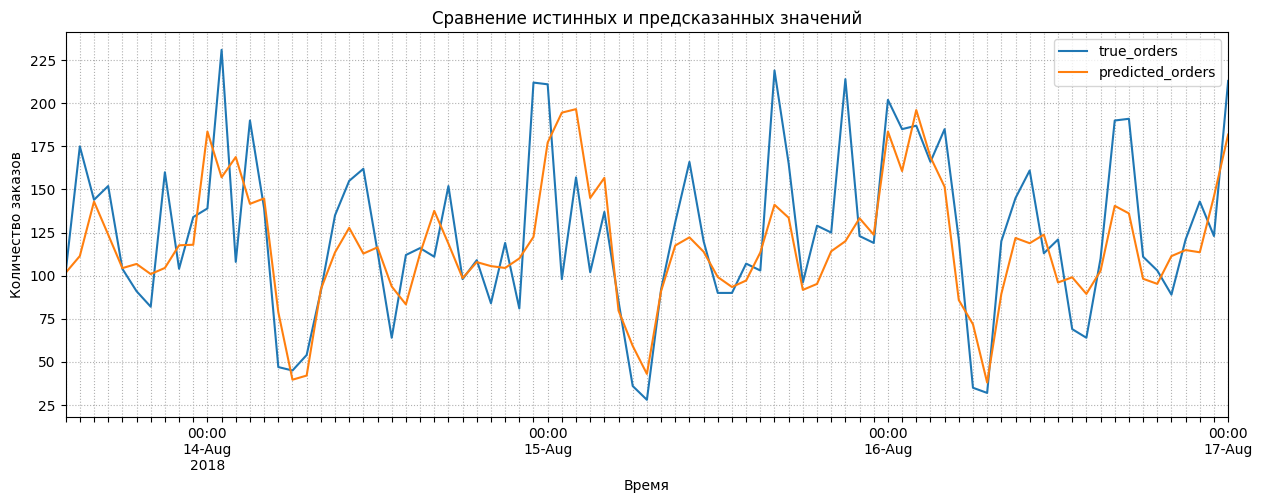

In [19]:
fig, ax = plt.subplots(figsize=(15,5))
plt_data['2018-08-13 00:00:00':'2018-08-17 00:00:00'].plot(
    ax= ax,
    title='Сравнение истинных и предсказанных значений',
    xlabel='Время',
    ylabel='Количество заказов'
)
ax.set_xticks(plt_data['2018-08-13 00:00:00':'2018-08-17 00:00:00'].index)
plt.grid(True, linestyle = ':')
plt.show()

Видно, что модель "более значительно" ошибается в пиковых значениях в районе 0 часов, а также сглаживает некоторые другие локальные пиковые значения

## Общий вывод

Анализ исходых данных показал, что временной ряд имеет сезонную и трендовую составляющую. При моделировании с использованием кросс-валидации в пайплайн сравнивались модели LinearRegression, DecisionTreeRegressor, LGBMRegressor и CatBoostRegressor с перебором гиперпараметров. Лучший результат (RMSE=44.42 на тестовой выборке) показала модель LGBMRegressor (max_depth=6, num_leaves=12), что соответствует критерию поставленной задачи (значение метрики RMSE на тестовой выборке должно быть не больше 48), поэтому она может быть рекомендована к применению для решения бизнес-задачи построения прогноза заказов такси на следующий час.

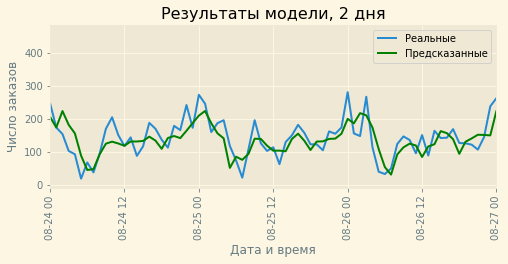